## Collab setup

In [ ]:
!pip install pycbc lalsuite bilby nestle gwpopulation matplotlib

## PC setup

### Using anaconda/miniconda
`conda env create -f environment.yaml`

`conda activate np3m`

OR

### Using pip
Create a python virtual environment and 
`pip install -r requirements.txt`

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import dynesty
from dynesty import DynamicNestedSampler

# Define the model

In [3]:
def linear_model(x, parameters):

    m, c = parameters
    return m*x + c


def quadratic_model(x, parameters):

    a, b, c = parameters
    return a*x**2 + b*x + c



# Create mock data

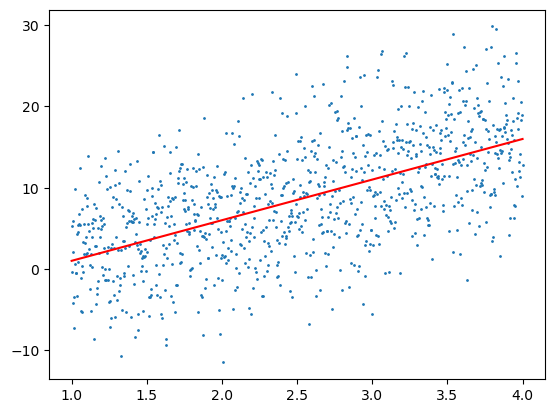

In [70]:
Npoints = 1000

x = np.linspace(1, 4, Npoints)

sigma = 6

noise = sigma*np.random.randn(Npoints)
m0, c0 = 5, -4

l_truths  = np.array([m0, c0])

signal = linear_model(x, l_truths)

data = signal + noise


plt.scatter(x, data, s=1)
plt.plot(x, signal, c='red')
plt.show()

# Define likelihood and prior

In [71]:
class SimpleLikelihoodModel:
    def __init__(self, x, data, model):
        self.x = x
        self.data = data
        self.model  = model


    def loglikelihood(self, parameters):

        prediction = self.model(self.x, parameters)

        return -0.5* np.sum ( ((self.data - prediction)/sigma)**2)
    

# Setup sampler

In [72]:
def l_priors(parameters_t):

    m_t, c_t = parameters_t

    m = 10*m_t
    c = -10 + 20*c_t

    return np.array([m, c])


slm = SimpleLikelihoodModel(x=x,
                            data=data,
                            model=linear_model)

l_sampler = DynamicNestedSampler(loglikelihood=slm.loglikelihood,
                               prior_transform=l_priors,
                               nlive=100,
                               ndim=2)



In [73]:

l_sampler.run_nested()

12578it [00:08, 1525.59it/s, batch: 31 | bound: 2 | nc: 1 | ncall: 32812 | eff(%): 38.316 | loglstar: -499.421 < -496.966 < -497.441 | logz: -503.619 +/-  0.074 | stop:  0.979]    


In [74]:
from dynesty.plotting import cornerplot, traceplot, runplot

(<Figure size 1600x1600 with 4 Axes>,
 array([<Axes: xlabel='$-\\ln X$', ylabel='Live Points'>,
        <Axes: xlabel='$-\\ln X$', ylabel='Likelihood\n(normalized)'>,
        <Axes: xlabel='$-\\ln X$', ylabel='Importance\nWeight PDF'>,
        <Axes: xlabel='$-\\ln X$', ylabel='Evidence'>], dtype=object))

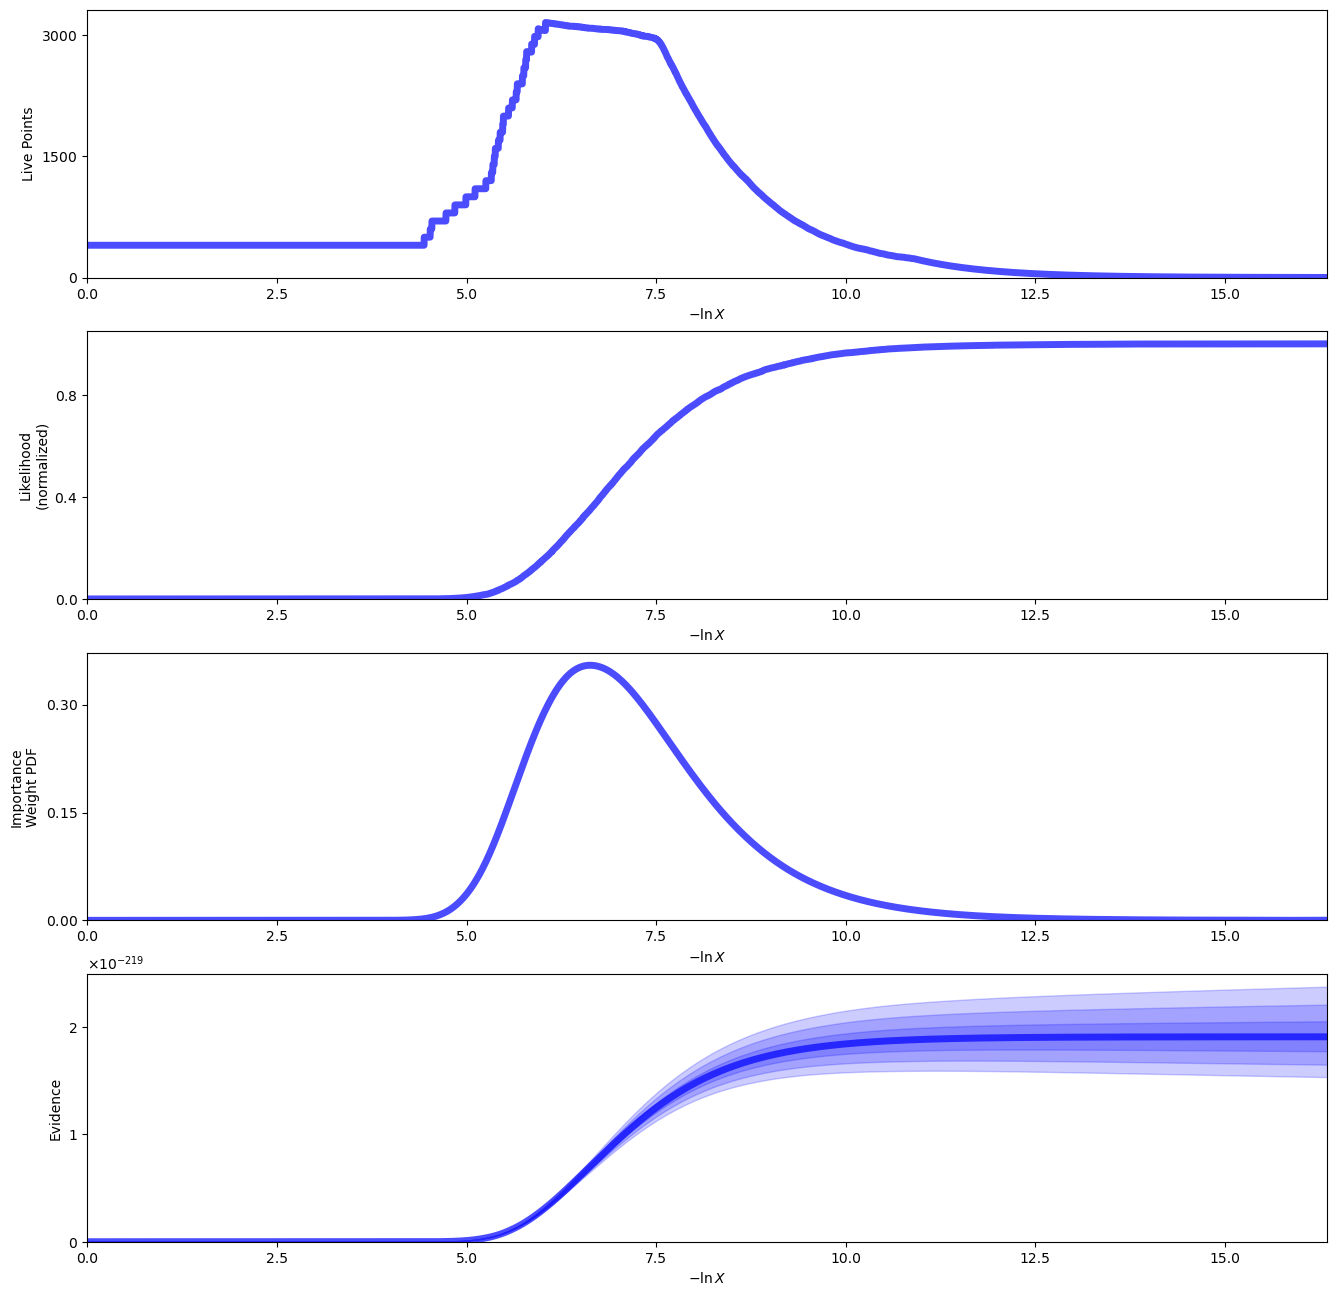

In [121]:
runplot(l_sampler.results)

(<Figure size 1200x600 with 4 Axes>,
 array([[<Axes: xlabel='$-\\ln X$', ylabel='$x_{1}$'>,
         <Axes: xlabel='$x_{1}$'>],
        [<Axes: xlabel='$-\\ln X$', ylabel='$x_{2}$'>,
         <Axes: xlabel='$x_{2}$'>]], dtype=object))

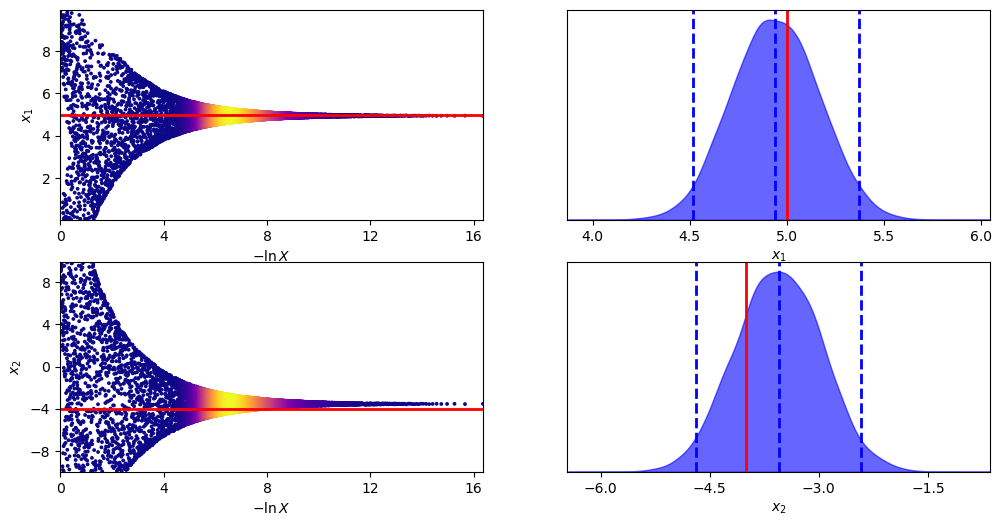

In [75]:
traceplot(l_sampler.results, truths=l_truths)

(<Figure size 550x550 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='$x_{1}$', ylabel='$x_{2}$'>,
         <Axes: xlabel='$x_{2}$'>]], dtype=object))

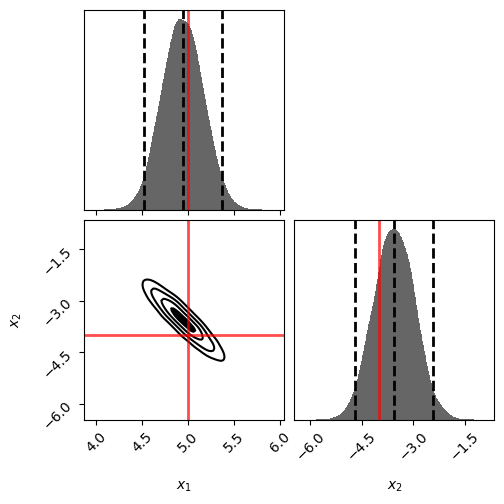

In [98]:
cornerplot(l_sampler.results, truths=l_truths)

In [76]:
n1 = int(0.68*len(l_sampler.results.samples))

samples = l_sampler.results.samples
logl = l_sampler.results.logl
order = np.argsort(logl)[::-1]

rlogl = logl[order]
rsamples = samples[order]


fsamples = []
for idx in range(n1):
    fsamples.append(rsamples[idx])

fsamples = np.array(fsamples)

In [77]:
fsamples[:, 0]

array([4.93641521, 4.9454641 , 4.93755182, ..., 4.51905254, 5.14397245,
       5.09197641])

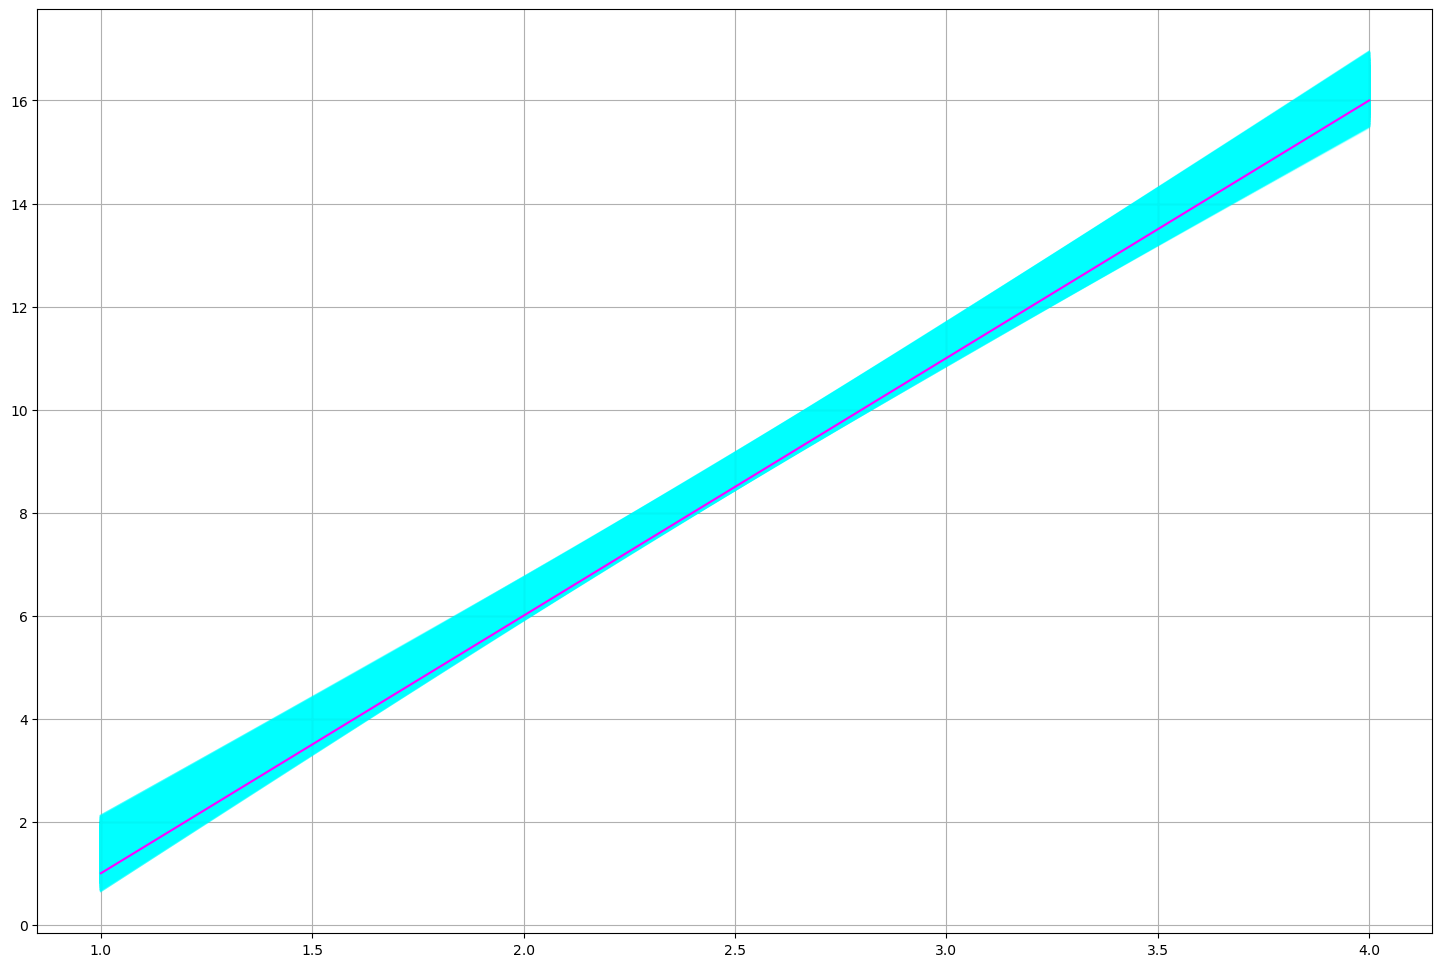

In [86]:
fig, ax = plt.subplots(figsize=(18, 12))


for sample in fsamples:
    ax.plot(x, linear_model(x, sample), c='cyan', alpha=0.1)

ax.grid()
ax.plot(x, linear_model(x, l_truths), c='magenta')
plt.show()

In [106]:
ev_l = l_sampler.results.logz[-1]

## Quadratic model

In [111]:
def q_priors(parameters_t):

    a_t, b_t, c_t = parameters_t

    a = -10 + 20*a_t
    b = -10 + 20*b_t
    c = -10 + 20*c_t

    return np.array([a, b, c])


sqm = SimpleLikelihoodModel(x=x,
                            data=data,
                            model=quadratic_model)

q_sampler = DynamicNestedSampler(loglikelihood=sqm.loglikelihood,
                               prior_transform=q_priors,
                               nlive=100,
                               ndim=3)


In [112]:

q_sampler.run_nested()

13277it [00:05, 2653.77it/s, batch: 27 | bound: 4 | nc: 1 | ncall: 35414 | eff(%): 37.405 | loglstar: -498.638 < -496.013 < -496.713 | logz: -506.838 +/-  0.096 | stop:  0.980]    


(<Figure size 1200x900 with 6 Axes>,
 array([[<Axes: xlabel='$-\\ln X$', ylabel='$x_{1}$'>,
         <Axes: xlabel='$x_{1}$'>],
        [<Axes: xlabel='$-\\ln X$', ylabel='$x_{2}$'>,
         <Axes: xlabel='$x_{2}$'>],
        [<Axes: xlabel='$-\\ln X$', ylabel='$x_{3}$'>,
         <Axes: xlabel='$x_{3}$'>]], dtype=object))

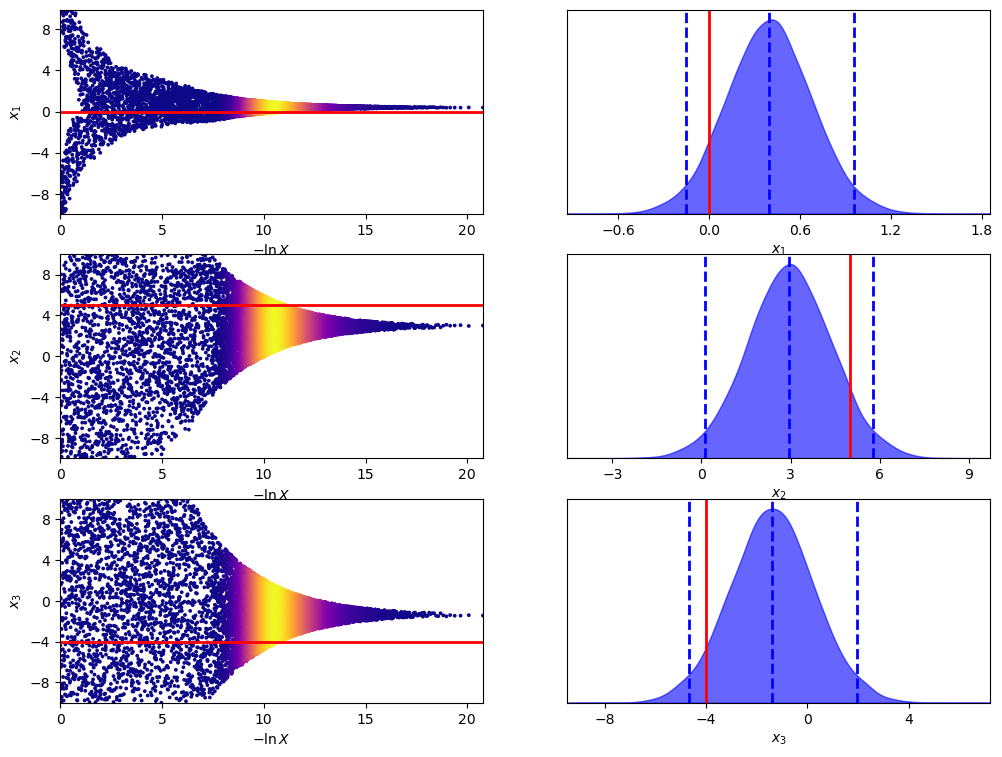

In [113]:
traceplot(q_sampler.results, truths=[0, m0, c0])

(<Figure size 760x760 with 9 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='$x_{2}$'>, <Axes: >, <Axes: >],
        [<Axes: xlabel='$x_{1}$', ylabel='$x_{3}$'>,
         <Axes: xlabel='$x_{2}$'>, <Axes: xlabel='$x_{3}$'>]], dtype=object))

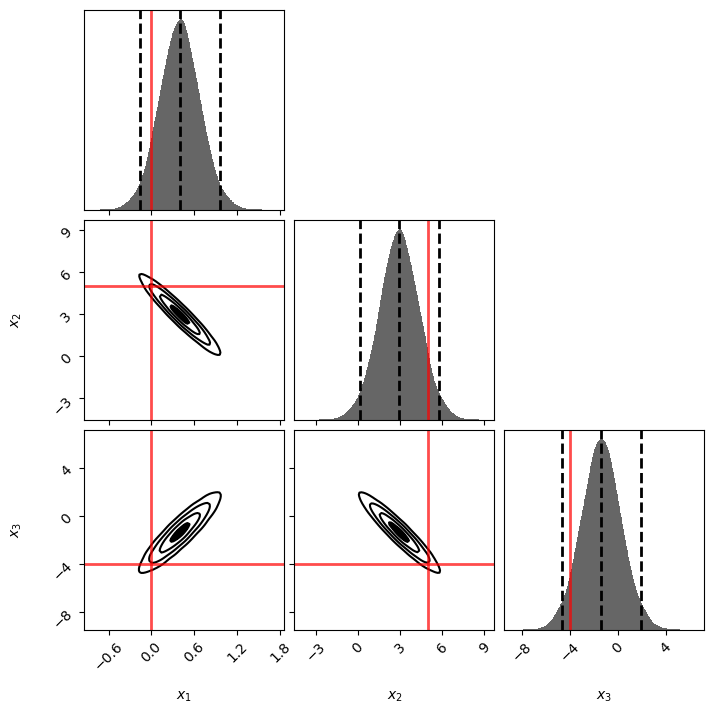

In [114]:
cornerplot(q_sampler.results, truths=[0, m0, c0])

In [115]:
ev_q = q_sampler.results.logz[-1]

In [118]:
logB = ev_l - ev_q

In [120]:
B = 10**(logB)

print(B)

1656.4286925585704
